# DSCI 633 Project
### Predicting Readmittance within 30 Days for Hospitalized Diabetes Patients  
*Michael Eaton, Rochester Institute of Technology — Fall 2025*


In [152]:
from ucimlrepo import fetch_ucirepo 
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline


In [153]:
os.makedirs('../data', exist_ok=True)

In [154]:
# fetch dataset 
diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296) 
  
# data (as pandas dataframes) 
X: pd.DataFrame = diabetes_130_us_hospitals_for_years_1999_2008.data.features  # type: ignore
y :pd.DataFrame = diabetes_130_us_hospitals_for_years_1999_2008.data.targets.copy()  # type: ignore


/home/mike/Git-projects/Eaton_633_Project/.venv/lib/python3.13/site-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


## Data Cleaning

Fix columns not read as strings

In [155]:
y['readmitted'] = y['readmitted'].astype('string')

y['target'] = (y['readmitted'] == '<30').astype(int)


# drop weight and payer_code missing and un informative
X_0 = X.drop(columns=['weight', 'payer_code'])


# fix diag column types
X_0['diag_1'] = X_0['diag_1'].astype('string')
X_0['diag_2'] = X_0['diag_2'].astype('string')
X_0['diag_3'] = X_0['diag_3'].astype('string')

# fix specialty column type
X_0['medical_specialty'] = X_0['medical_specialty'].astype('string')

# fix race
X_0['race'] = X_0['race'].astype('string')

# fix age
X_0['age'] = X_0['age'].astype('string')

X_0['change'] = X_0['change'].astype('string')


In [156]:
# drop the newborn rows
newborn = (X_0['admission_type_id'] == 4) | (X_0['discharge_disposition_id'] == 10)

_pre = len(X_0)


X_1 = X_0.loc[~newborn].reset_index(drop=True)
y   = y.loc[~newborn].reset_index(drop=True)
print(f'dropped: {_pre - len(X_1)}')

dropped: 16


In [157]:
# Drop rows with invalid gender
valid_gender = (X_1['gender'] == 'Male') | (X_1['gender'] == 'Female')
_pre = len(X_1)
X_2 = X_1.loc[valid_gender].reset_index(drop=True)
y   = y.loc[valid_gender].reset_index(drop=True)
print(f'dropped: {_pre - len(X_2)}')

dropped: 3


Drop the rows that contain information about a patient Expiring. These rows leak future information and was dropped in the study by Strack et al.

In [158]:
# drop rows that show a patient expired

# from mapping info
_c = 'discharge_disposition_id'
exp_mask = (X_2[_c] == 11) | ((X_2[_c] > 18) & (X_2[_c] < 21))

_pre = len(X_2)
X_3 = X_2.loc[~exp_mask].reset_index(drop=True)
y   = y.loc[~exp_mask].reset_index(drop=True)
print(f'dropped: {_pre - len(X_3)}')

dropped: 1652


After examining the numercial features further, the data showed that number_outpatient, number_emergency, and number_inpatient were heavily right skewed with the vast majority of data consisting of 0 of each visit type.

However, number_inpatient has shown to be a dominant factor in model predictions.

After testing combining the patient visit columns, recall dropped slightly in our random forest model without any increase in ROC_AUC or other metric changes so this seems like a poor decision - loss of information with no gain

In [159]:
# X_0['num_vists'] = X_0[['number_outpatient', 'number_emergency', 'number_inpatient']].sum(axis=1)
# X_0 = X_0.drop(columns=['number_outpatient', 'number_emergency', 'number_inpatient'])

## Feature Engineering
Bin, organize, impute missing data, drop some un-needed columns. 

The strategy that follows is based off of the strategy performed by Strack et al. in their study: 

*Impact of HbA1c Measurement on Hospital Readmission Rates:
Analysis of 70,000 Clinical Database Patient Records*

I'll start by copying the binning strategy used to limit feature explosion

diagnoses, medical specialty, discharge, admission source, age are binned exactly as in the mentioned study

a1c results are binned into 3 groups, not in the same way as the study. They are split into (high, normal, and no test) with no test being the majority category by far.
The change is due to the changed nature of the goals of our analysis, just prediction of readmittance instead of viewing the effects of performing the A1c test

glucose tests are binned in the same way as A1c results

Admission type is binned based on the following:
- NA - missing values, null, not mapped
- emergency - emergency, trauma center (highest level of urgency)
- urgent - urgent (middle level urgency)
- elective - elective (from a regularly scheduled prodecure)
- newborn - dropped as newborns data is not related to the group of interest

In [160]:
# bin diagnoses into groups 
_icd_num_re = re.compile(r'^(\d{3})(?:\.\d+)?$')   # e.g., '250.13' -> '250'

def _parse_icd9(code):
    """
    Returns (prefix, num) where:
      - prefix is 'E', 'V', or '' for numeric codes
      - num is an integer 3-digit number if numeric; else None
    """
    if code is None or (isinstance(code, float) and np.isnan(code)):
        return '', None
    s = str(code).strip()
    if not s:
        return '', None
    first = s[0].upper()
    if first in ('E', 'V'):
        return first, None
    m = _icd_num_re.match(s)
    if m:
        return '', int(m.group(1))
    # Try float -> int of floor integer part
    try:
        return '', int(float(s))
    except Exception:
        return '', None

def icd9_to_group(code):
    """
    Map a single ICD-9 code to the study's diagnosis group.
    """
    prefix, num = _parse_icd9(code)

    # External causes (E or V) 
    if prefix in ('E', 'V'):
        return 'other'

    if num is None:
        return 'other'

    # Special case: Diabetes 250.xx
    if 250 <= num <= 250:
        return 'diabetes'

    # Primary named groups
    if (390 <= num <= 459) or (num == 785):
        return 'circulatory'
    if (460 <= num <= 519) or (num == 786):
        return 'respiratory'
    if (520 <= num <= 579) or (num == 787):
        return 'digestive'
    if 800 <= num <= 999:
        return 'injury'
    if 710 <= num <= 739:
        return 'musculoskeletal'
    if (580 <= num <= 629) or (num == 788):
        return 'genitourinary'
    if 140 <= num <= 239:
        return 'neoplasms'

    return 'other'

In [161]:
# Admission source -> 3 bins
def bin_admit_source(id: int) -> str:
    if id == 7:
        return 'emergency'
    if id == 1 or id == 2:
        return 'refer'
    return 'other'


In [162]:
# Medical Specialty of admitting physician -> 6 bins including missing
def bin_medical_specialty(value: str) -> str:
    if pd.isna(value) or value in ("Missing", "Unknown", "PhysicianNotFound", "OutreachServices", "DCPTEAM"):
        return "missing"
    
    # normalize casing and spacing just in case
    val = str(value).strip().lower()
    
    # Internal Medicine
    if "internal" in val:
        return "internal_medicine"
    
    # Cardiology
    if "cardio" in val:
        return "cardiology"
    
    # Surgery (catch-all for surgical specialties)
    if "surg" in val or "orthopedic" in val or "urology" in val or "gyneco" in val or "neuro" in val or "vascular" in val or "thoracic" in val:
        return "surgery"
    
    # Family / General Practice
    if "family" in val or "general" in val or "gp" in val or "obstetric" in val or "pediatr" in val:
        return "pcp"
    
    # Everything else
    return "other"


In [163]:
# Discharge Dispostion -> 
def bin_discharge(id: int) -> str:
    if id in [1, 6, 8, 13]:
        return 'home'
    if id in [2, 3, 4, 5, 15, 22, 23, 24, 27, 28, 29, 30]:
        return 'transfer_inpatient'
    if id in [16, 17, 12]:
        return 'outpatient_followup'
    if id == 7:
        return 'left_ama'
    if id in [18, 25, 26]:
        return 'unknown'
    return 'unknown'
    

In [164]:
# bin race -> Hispanic/Asian -> other since they have few values
def bin_race(race: str) -> str:
    if (pd.isna(race)):
        return "other"
    race = race.strip().lower()
    if race == "caucasian":
        return "caucasian"
    if race == "africanamerican":
        return "african_american"
    return "other"

In [165]:
# bin admission type id 
def bin_admit_type(id: int) -> str:
    if id in [5, 6, 8]: # Not Available, NULL, Not mapped
        return 'na'
    if id in [1,7]: # Emergency, Trauma Center
        return 'emergency'
    if id == 2:
        return 'urgent'
    if id == 3:
        return 'elective'
    return 'other'


In [166]:
# bin age -> 3 groups
def bin_age(age: str) -> str:
    # grabs [0-10], [10-20], [20-30]
    if ('10' in age or '20' in age):
        return '<30'
    # grabs (30-40), (40-50), (50-60)
    if ('40' in age or '50' in age):
        return '30-60'
    return '>60'

In [167]:
# bin a1c results
def bin_a1c(val: str) -> str:
    if pd.isna(val):
        return 'no_test'
    if val in ('>7', '>8'):
        return 'high'
    if val.lower().startswith('norm'):
        return 'normal'
    return 'no_test'

In [168]:
def bin_glucose(val: str) -> str:
    if pd.isna(val):
        return 'no_test'
    if val in ('>200', '>300'):
        return 'high'
    if val.lower().startswith('norm'):
        return 'normal'
    return 'no_test'

Apply the categorical transformations

In [169]:
X_3['diag1_group'] = X_3['diag_1'].apply(icd9_to_group)
X_3['diag2_group'] = X_3['diag_2'].apply(icd9_to_group)
X_3['diag3_group'] = X_3['diag_3'].apply(icd9_to_group)
X_3['admission_source'] = X_3['admission_source_id'].apply(bin_admit_source)
X_3['discharge_loc'] = X_3['discharge_disposition_id'].apply(bin_discharge)
X_3['specialty_cat'] = X_3['medical_specialty'].apply(bin_medical_specialty)
X_3['race_cat'] = X_3['race'].apply(bin_race)
X_3['age_group'] = X_3['age'].apply(bin_age)
X_3['a1c_group'] = X_3['A1Cresult'].apply(bin_a1c)
X_3['glucose_group'] = X_3['max_glu_serum'].apply(bin_glucose)
X_3['admit_type_group'] = X_3['admission_type_id'].apply(bin_admit_type)

In [170]:
# print info about the majority category of each column of interest
cols_to_check =['diag1_group',
                'admission_source',
                'discharge_loc',
                'specialty_cat',
                'race_cat',
                'age_group',
                'gender',
                'a1c_group',
                'glucose_group',
                'admit_type_group'
                ]

most_common_summary = pd.DataFrame(
    [
        {
            "column": col,
            "most_common": (vc := X_3[col].value_counts(dropna=False)).idxmax(),
            "count": vc.max()
        }
        for col in cols_to_check
    ]
)

print(most_common_summary)

             column  most_common  count
0       diag1_group  circulatory  29875
1  admission_source    emergency  56356
2     discharge_loc         home  73631
3     specialty_cat      missing  49142
4          race_cat    caucasian  74835
5         age_group          >60  64439
6            gender       Female  53854
7         a1c_group      no_test  83222
8     glucose_group      no_test  94876
9  admit_type_group    emergency  52900


Drop the old columns

In [171]:

# drop previous columns in favor of new groups
X_4 = X_3.drop(
    columns=['diag_1', 
             'diag_2', 
             'diag_3', 
             'admission_source_id',
             'discharge_disposition_id',
             'medical_specialty',
             'race',
             'age',
             'A1Cresult',
             'max_glu_serum',
             'admission_type_id'
             ])

One hot encode the new categories

In [172]:
# one hot categorical columns
X_5 = pd.get_dummies(X_4, 
                     columns=[  'diag1_group', 
                                'diag2_group', 
                                'diag3_group', 
                                'admission_source',
                                'discharge_loc',
                                'specialty_cat',
                                'race_cat',
                                'age_group',
                                'gender',
                                'a1c_group',
                                'glucose_group',
                                'admit_type_group'
                              ],
                              dtype=int)

print(f'num features before: {len(X_4.columns)}')
print(f'num features after: {len(X_5.columns)}')
# prefer lower case
X_5 = X_5.rename(columns={'gender_Female' : 'gender_female', 'gender_Male' : 'gender_male'})





num features before: 45
num features after: 92


Handle drug columns by swapping them to binary flags

In [173]:
# swap to binary flags
X_5['diabetesMed_flag'] = (X_5['diabetesMed'].str.lower() == 'yes').astype(int)
X_5['change_flag'] = (X_5['change'].str.lower() == 'ch').astype(int)



# dump frame before we start dropping columns, for potential deep models if used
X_5.to_csv('../data/full_frame.csv')


drug_cols = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
    'examide', 'citoglipton', 'insulin', 'glyburide-metformin',
    'glipizide-metformin', 'glimepiride-pioglitazone',
    'metformin-rosiglitazone', 'metformin-pioglitazone'
]


for col in drug_cols:
    X_5[f'{col}_flag'] = (X_5[col].str.lower() != 'no').astype(int)


We take the sum of each column of drugs administered. 24 different drug columns is overkill for a linear model. This allows us to drop a significant amount of features without losing very much information. 

More advanced models might be able to handle the per drug information, which also includes values like 'up' 'down' for medication changes per drug

In [174]:
# sum across medicine for amount of medicine prescribed
X_5['num_drugs'] = X_5[[f'{c}_flag' for c in drug_cols]].sum(axis=1)

Drop one base category from each one hot group to avoid linear dependent columns

In [175]:
# generally we drop the most common class printed earlier:

#           column      most_common  count
# 0       diag1_group  Circulatory  30437
# 1  admission_source    emergency  57494
# 2     discharge_loc         home  60234
# 3     specialty_cat      Missing  49978
# 4          race_cat    Caucasian  76099
# 5         age_group          >60  65748
# 6            gender       Female  54708
# 7         a1c_group      No_test  84748
# 8     glucose_group      No_test  96420
# 9  admit_type_group    Emergency  54011

X_6 = X_5.drop(
    columns=[
        'diag1_group_circulatory', 
        'specialty_cat_missing', 
        'age_group_30-60', # mid age group
        'race_cat_caucasian', 
        'gender_male', # most common base for medical studies
        'discharge_loc_home', 
        'admission_source_other',
        'a1c_group_no_test',
        'glucose_group_no_test',
        'admit_type_group_emergency'
        
    ]
)

# drop other flag columns

X_7 = X_6.drop(
    columns=[
        'diabetesMed',
        'change'
    ]
)
# drop drug columns
X_8 = X_7.drop(
    columns=drug_cols
)

# keep insulin and metformin columns (binary yes no prescribed)
# these are the 2 major long term diatbetes treatment drugs and are most likely to have an effect on readmission
drug_cols.remove('insulin')
drug_cols.remove('metformin')

# Create the list of flag columns
flag_cols = [f"{c}_flag" for c in drug_cols]
# Drop them from the DataFrame
X_9 = X_8.drop(columns=flag_cols)





print(f'num features after drops: {len(X_9.columns)}')

X_9_w = pd.concat([X_9, y['target']], axis=1)
X_9_w.to_csv('../data/frame_no_interactions.csv')


num features after drops: 62


### Create interaction terms
Baseline will be the interaction terms that were found statistically signifigant in Strack et al.

That is (by P):
- Discharge disposition × Time in hospital (p < 0.001)
- Medical specialty of admitting physician × Age (p < 0.001)
- Primary diagnosis × Time in hospital (p < 0.001)
- Discharge disposition × Race (p < 0.001)
- Discharge disposition × Medical specialty of admitting physician (p = 0.001)
- Medical Specialty x Time in hospitcal (p = 0.001)

I'll leave out for now:
- Discharge disposition x Primary diagnosis (p = 0.005)
- Primary diagnosis x HbA1c (p = 0.004)


Categorical x numerical interactions

In [176]:
# Primary Diagnosis X Time in hospital interaction
X_10 = X_9.copy()
for col in X_10.filter(like='diag1_group_'):
    X_10[f'i_hosp_time__{col}'] = X_10[col] * X_10['time_in_hospital']
    print(f'added col: {f'i_hosp_time_{col}'}')
print('--')
# medical specialty of admitting physician x time in hospital
for col in X_10.filter(like='specialty_cat_'):
    X_10[f'i_hosp_time__{col}'] = X_10[col] * X_10['time_in_hospital']
    print(f'added col: {f'i_hosp_time_{col}'}')

print('--')

# Discharge Disposition x time in hospital
for col in X_10.filter(regex=r'^discharge_loc_'):
    X_10[f'i_hosp_time__{col}'] = X_10[col] * X_10['time_in_hospital']
    print(f'added col: {f'i_hosp_time__{col}'}')



print(f'num features after adding numerical interaction cols: {len(X_10.columns)}')

added col: i_hosp_time_diag1_group_diabetes
added col: i_hosp_time_diag1_group_digestive
added col: i_hosp_time_diag1_group_genitourinary
added col: i_hosp_time_diag1_group_injury
added col: i_hosp_time_diag1_group_musculoskeletal
added col: i_hosp_time_diag1_group_neoplasms
added col: i_hosp_time_diag1_group_other
added col: i_hosp_time_diag1_group_respiratory
--
added col: i_hosp_time_specialty_cat_cardiology
added col: i_hosp_time_specialty_cat_internal_medicine
added col: i_hosp_time_specialty_cat_other
added col: i_hosp_time_specialty_cat_pcp
added col: i_hosp_time_specialty_cat_surgery
--
added col: i_hosp_time__discharge_loc_left_ama
added col: i_hosp_time__discharge_loc_outpatient_followup
added col: i_hosp_time__discharge_loc_transfer_inpatient
added col: i_hosp_time__discharge_loc_unknown
num features after adding numerical interaction cols: 79


Categorical x Categorical interactions from one hot encoded columns

In [177]:
def add_dummy_interactions(df, left_cols, right_cols, prefix='i_'):
    out = df.copy()
    L = [c for c in left_cols  if c in out.columns]
    R = [c for c in right_cols if c in out.columns]
    count = 0
    for lc in L:
        for rc in R:
            col_name = f'{prefix}{lc}__{rc}'
            out[col_name] = out[lc] * out[rc]
            count += 1
            print(f'added col: {col_name}')

    print(f'added {count} interaction terms from')
    print(left_cols)
    print('x')
    print(right_cols)

    return out

In [178]:
# setup column lists
specialty_cols = X_10.filter(regex=r'^specialty_cat_').columns.to_list()
age_cols = X_10.filter(regex=r'^age_group_').columns.to_list()
diag_cols = X_10.filter(regex=r'^diag1_group_').columns.to_list()
race_cols = X_10.filter(regex=r'^race_cat_').columns.to_list()
discharge_cols = X_10.filter(regex=r'^discharge_loc_').columns.to_list()

In [179]:
# medical specialty of admitting physician x age bin
X_11= X_10.copy()
X_11 = add_dummy_interactions(
    X_11,
    left_cols=specialty_cols,
    right_cols=age_cols
)

# discharge dispo x race
X_11 = add_dummy_interactions(
    X_11,
    left_cols= discharge_cols,
    right_cols=race_cols
)

# discharge x specialty

X_11 = add_dummy_interactions(
    X_11,
    left_cols=discharge_cols,
    right_cols=specialty_cols
)

print(f'num features after adding categorical interaction cols: {len(X_11.columns)}')


added col: i_specialty_cat_cardiology__age_group_<30
added col: i_specialty_cat_cardiology__age_group_>60
added col: i_specialty_cat_internal_medicine__age_group_<30
added col: i_specialty_cat_internal_medicine__age_group_>60
added col: i_specialty_cat_other__age_group_<30
added col: i_specialty_cat_other__age_group_>60
added col: i_specialty_cat_pcp__age_group_<30
added col: i_specialty_cat_pcp__age_group_>60
added col: i_specialty_cat_surgery__age_group_<30
added col: i_specialty_cat_surgery__age_group_>60
added 10 interaction terms from
['specialty_cat_cardiology', 'specialty_cat_internal_medicine', 'specialty_cat_other', 'specialty_cat_pcp', 'specialty_cat_surgery']
x
['age_group_<30', 'age_group_>60']
added col: i_discharge_loc_left_ama__race_cat_african_american
added col: i_discharge_loc_left_ama__race_cat_other
added col: i_discharge_loc_outpatient_followup__race_cat_african_american
added col: i_discharge_loc_outpatient_followup__race_cat_other
added col: i_discharge_loc_trans

In [180]:
X_11_w = pd.concat([X_11, y['target']], axis=1)
X_11_w.to_csv('../data/linear_frame.csv')

In [181]:
print(f'number of features: {len(X_11.columns)}')

number of features: 117


In [182]:
X_11.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,diag1_group_diabetes,diag1_group_digestive,...,i_discharge_loc_transfer_inpatient__specialty_cat_cardiology,i_discharge_loc_transfer_inpatient__specialty_cat_internal_medicine,i_discharge_loc_transfer_inpatient__specialty_cat_other,i_discharge_loc_transfer_inpatient__specialty_cat_pcp,i_discharge_loc_transfer_inpatient__specialty_cat_surgery,i_discharge_loc_unknown__specialty_cat_cardiology,i_discharge_loc_unknown__specialty_cat_internal_medicine,i_discharge_loc_unknown__specialty_cat_other,i_discharge_loc_unknown__specialty_cat_pcp,i_discharge_loc_unknown__specialty_cat_surgery
0,1,41,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0
1,3,59,0,18,0,0,0,9,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,11,5,13,2,0,1,6,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,44,1,16,0,0,0,7,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,51,0,8,0,0,0,5,0,0,...,0,0,0,0,0,0,0,0,0,0


Attempting to run some plots of the features was frivolous with 97, mostly on hot encoded categorical, features

Running PCA to see what happens

In [183]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_11, y, test_size=0.2, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


pca = PCA(n_components=0.94)
X_pca = pca.fit_transform(X_train_scaled)
print(f'num features after PCA: {X_pca.shape[1]}')


num features after PCA: 79


curious what the graph of n_components / num features after PCA looks like

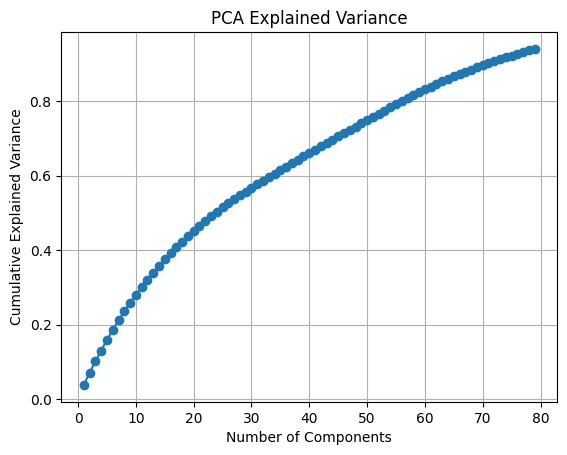

In [184]:
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()


In [185]:
# dump pca info to file for use in another notebook

import joblib

joblib.dump((X_pca, X_train_scaled, X_test_scaled, y_test, y_train), '../data/pca_pipeline.joblib')


['../data/pca_pipeline.joblib']

After finishing preliminary data preperation, I provided the notebook to gemini for critque.

That conversation can be referenced here: https://g.co/gemini/share/885bb5d34ee5

The review lead to 2 changes:

1. Apply the StandardScalar and train_test_split to the dataset before running PCA
2. Addition of 'insulin' and 'metformin' flag columns in the dataset, when before I was dropping them. This seems logical to try and keep more information about the most important drugs.

I also added a note about increasing the number of bins for discharge disposition, but for now have left it the same as Strack et al.
